# Keyword Transformer model used for training


In [1]:
"""Neccessary modules to import"""
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    LayerNormalization,
)
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import numpy as np
from itertools import chain
import os
import librosa
from audiomentations import Compose, AddBackgroundNoise, SpecFrequencyMask, TimeMask, Resample
from tqdm import tqdm
from argparse import ArgumentParser
from shutil import copyfile
import scipy.io.wavfile as wav
import struct
import time
import sys
from collections import namedtuple
import json
import random
import time



2023-05-30 16:57:36.956174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    """
    Class for Multi Head Self Attention layer
    """
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
#         self.initializer = tf.
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(
            x, (batch_size, -1, self.num_heads, self.projection_dim)
        )
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )
        output = self.combine_heads(concat_attention)
        return output


class TransformerBlock(tf.keras.layers.Layer):
    """
    Prenorm transformer block of  KWS streaming layer.
    """
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.mlp = tf.keras.Sequential(
            [
                Dense(mlp_dim, activation=tfa.activations.gelu),
                Dropout(dropout),
                Dense(embed_dim),
                Dropout(dropout),
            ]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training):
        inputs_norm = self.layernorm1(inputs)
        attn_output = self.att(inputs_norm)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = attn_output + inputs
        # print(f'out 1 shape: {out1.shape}')

        out1_norm = self.layernorm2(out1)
        mlp_output = self.mlp(out1_norm)
        mlp_output = self.dropout2(mlp_output, training=training)
        # print(f'mlp output shape: {mlp_output.shape}')

        return mlp_output + out1


class KWS_transformer(tf.keras.Model):
    """
    Model architecture of main Key Word Spotting model
    """
    def __init__(self, image_size, patch_size, num_layers, num_classes, d_model, num_heads, mlp_dim, channels=1,
                 dropout=0.1, ):
        super(KWS_transformer, self).__init__()
        self.image_width = image_size[0]
        self.image_height = image_size[1]
        self.patch_width = patch_size[0]
        self.patch_height = patch_size[1]
        self.d_model = d_model
        self.num_layers = num_layers

        num_patches = int((self.image_width * self.image_height) / (self.patch_width * self.patch_height))
        patch_dim = channels * self.patch_width * self.patch_height
        self.patch_dim = patch_dim

        self.pos_emb = self.add_weight("pos_emb", shape=(1, num_patches + 1, d_model))
        self.patch_proj = Dense(d_model)
        self.class_emb = self.add_weight("class_emb", shape=(1, 1, d_model))

        self.enc_layers = [
            TransformerBlock(d_model, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ]

        self.mlp_head = tf.keras.Sequential(
            [
                LayerNormalization(epsilon=1e-6),
                Dense(num_classes)
            ]
        )

    def extract_patches(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_width, self.patch_height, 1],
            strides=[1, self.patch_width, self.patch_height, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patches = tf.reshape(patches, [batch_size, -1, self.patch_dim])
        return patches

    def call(self, x, training):
        batch_size = tf.shape(x)[0]
        patches = self.extract_patches(x)

        x = self.patch_proj(patches)

        class_emb = tf.broadcast_to(self.class_emb, [batch_size, 1, self.d_model])
        x = tf.concat([class_emb, x], axis=1)
        x = x + self.pos_emb

        for layer in self.enc_layers:
            x = layer(x, training)

        x = self.mlp_head(x[:, 0])
        # print(x.shape)
        return x

In [3]:
parser = ArgumentParser()
parser.add_argument("--data_dir", default="data4/")
parser.add_argument("--logdir", default="logs")
parser.add_argument("--num_layers", default=12, type=int)
parser.add_argument("--d_model", default=64, type=int)
parser.add_argument("--num_heads", default=1, type=int)
parser.add_argument("--mlp_dim", default=256, type=int)
parser.add_argument("--lr", default=0.001, type=float)
parser.add_argument("--weight_decay", default=1e-4, type=float)
parser.add_argument("--batch_size", default=128, type=int)
parser.add_argument("--epochs", default=200, type=int)
parser.add_argument("--save_dir", default="adv_KWS_transformer2")
args = parser.parse_args([])
print(vars(args))
!mkdir adv_tmp

{'data_dir': 'data4/', 'logdir': 'logs', 'num_layers': 12, 'd_model': 64, 'num_heads': 1, 'mlp_dim': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 128, 'epochs': 200, 'save_dir': 'adv_KWS_transformer2'}
/bin/bash: /home/ritik/miniconda3/envs/project/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mkdir: cannot create directory ‘adv_tmp’: File exists


In [4]:
def convert_to_mfccs(data, perm=None):
#     print(data.shape)
    stfts = tf.signal.stft(tf.squeeze(data), frame_length=480, frame_step=160,
                           fft_length=480)
    spectrograms = tf.abs(stfts)

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 20.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, 16000, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms and take the first 13.
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
      log_mel_spectrograms)[..., :40]
    
    if perm is not None:
        mfccs = tf.transpose(mfccs).numpy()
        mfccs = tf.convert_to_tensor(mfccs[perm])
        mfccs = tf.transpose(mfccs, perm=[2, 0, 1])
    else:
        mfccs = tf.transpose(mfccs, perm=[0, 2, 1])
    mfccs = tf.expand_dims(mfccs, axis=-1)
    return mfccs

In [5]:
def load_files(data_dir='data'):
    """
    Loads the speech command data directory and returns the files and the labels
    :param data_dir:  path to directory containing audio files
    :return: filenames, commands
    """
    print(data_dir, '\n\n\n\n')
    commands = np.array(tf.io.gfile.listdir(str(data_dir)))
#     not_needed = ['README.md', 'speech_commands_v0.01.tar.gz', 'validation_list.txt', 'testing_list.txt', 'LICENSE',
#                   '.DS_Store', '_background_noise_']
    #commands = ['on', 'off', 'yes', 'no', 'stop', 'go', 'left', 'right', 'up', 'down']
    commands = ['on', 'off']
    filenames = []
    for i in range(len(commands)):
        filenames.append(tf.io.gfile.glob(str(data_dir) + "/" + commands[i] + "/*.wav"))
    filenames = list(chain.from_iterable(filenames))
    filenames = tf.random.shuffle(filenames)
    num_samples = len(filenames)
    print('Number of total examples:', num_samples)
    # print('Number of examples per label:',
    #       len(tf.io.gfile.listdir(os.path.join(data_dir, commands[0]))))
    # print('Example file tensor:', filenames[0])
#     print(filenames)
#     with open("filenames.txt", 'w') as f:
#         for x in filenames:
#             f.write(x + '\n')
    return filenames, commands

In [6]:
def load_train_test_val_files(filenames, data_dir):
    """
    Takes a list of files as input and returns list of train files, val files and test files
    :param filenames: List of audio files
    :param data_dir: Path to audio files
    :return: train files, test files and val files
    """
    with open(os.path.join(data_dir, 'validation_list.txt'), 'r') as f:
        list_of_val_data = f.read().splitlines()

    with open(os.path.join(data_dir, 'testing_list.txt'), 'r') as f:
        list_of_test_data = f.read().splitlines()

    train_files = []
    val_files = []
    test_files = []
    for i in filenames:
        current_file = i.numpy().decode('utf-8')
        main_dir, label, data = current_file.rsplit('/', 2)
        input_data = '/'.join((label, data))

        if input_data in list_of_val_data:
            input_data = "/".join((data_dir, input_data))
            val_files.append(input_data)
        elif input_data in list_of_test_data:
            input_data = "/".join((data_dir, input_data))
            test_files.append(input_data)
        else:
            input_data = "/".join((data_dir, input_data))
            train_files.append(input_data)
    print("Completed loading train files, test files and validation files")
    return train_files, test_files, val_files


In [7]:
def get_label(file_path):
    """
    Returns label of an audio file
    :param file_path:
    :return: Label
    """
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

In [8]:
def get_mfccs(file_path):
    """
    Takes an audio file and returns mfcc of the audio file. This will be used to generate
    the mfcc of validation audio files and test audio files
    :param file_path: audio file in wav format
    :return: mfcc
    """
    #loads the audio wavefile as numpy array 
    signal, sr = librosa.load(file_path, sr=16000)
    #edit the signal to length of duration of signal to 16000
    edited_signal = librosa.util.fix_length(signal, 16000)
#     log_spect = np.log(get_spectrogram(edited_signal) + 1e-6)

#     mfccs = librosa.feature.mfcc(y=edited_signal, n_mfcc=40, sr=sr, S=log_spect)
    return edited_signal


def get_mfccs_augmented(file_path, data_dir):
    """
    Takes an audio file and returns augmented mfcc of the audio file. This will be used to
    generate the mfcc of training set audio files
    :param file_path: audio file in wav format
    :param data_dir:
    :return:
    """
    signal, sr = librosa.load(file_path, sr=16000)
    edited_signal = librosa.util.fix_length(signal, 16000)
    start_ = int(np.random.uniform(-1600, 1600))
    if start_ >= 0:
        wav_time_shift = np.r_[edited_signal[start_:], np.random.uniform(-0.001, 0.001, start_)]
    else:
        wav_time_shift = np.r_[np.random.uniform(-0.001, 0.001, -start_), edited_signal[:start_]]

    augment = Compose([
        Resample(min_sample_rate=16000 * 0.85, max_sample_rate=16000 * 1.15),
        TimeMask(min_band_part=0.0, max_band_part=0.255),
        AddBackgroundNoise(sounds_path=os.path.join(data_dir, '_background_noise_'))
    ])
    edited_signal = augment(samples=wav_time_shift, sample_rate=16000)
    edited_signal = librosa.util.fix_length(edited_signal, 16000)
#     spect = get_spectrogram(edited_signal)
#     spect = SpecFrequencyMask(min_mask_fraction=0, max_mask_fraction=0.175)(spect)

#     log_spec = np.log(spect + 1e-6)

#     mfccs = librosa.feature.mfcc(y=edited_signal, n_mfcc=40, sr=sr, S=log_spec)
    return edited_signal

In [9]:
def create_example(fp, commands, data_dir, trainable=True):
    """

    :param fp: file path
    :param commands: list of labels
    :param data_dir: directory of audio files
    :param trainable: bool parameter for creating train set or test set and val set
    :return:mfcc, label
    """
    file_path = fp
    if trainable:
        mfccs = get_mfccs_augmented(file_path, data_dir)
    else:
        mfccs = get_mfccs(file_path)
    label = get_label(file_path)
    label = label.numpy().decode('utf-8')
    label_id = [i for i in range(len(commands)) if commands[i] == label][0]
#     if mfccs.shape != (40, 98):
#         print(mfccs.shape)
        # print("not padded")
    return np.expand_dims(mfccs, axis=-1), label_id

In [10]:
def load_data(train_files, test_files, val_files, commands, data_dir):
    """
    creates training, testing and validation data and labels
    :param train_files:
    :param test_files:
    :param val_files:
    :param commands:
    :param data_dir:
    :return: train_data, train_label, test_data, test_label, val_data, val_label
    """

    train_data = []
    train_label = []
    val_data = []
    val_label = []
    test_data = []
    test_label = []

    for fp in tqdm(train_files):

        data, label = create_example(fp, commands, data_dir,trainable=True)
        train_data.append(data)
        train_label.append(label)

    train_data = np.array(train_data, dtype=np.float32)
    train_label = np.array(train_label, dtype=np.float32)
    print(f"Train data shape: {train_data.shape}, train label shape: {train_label.shape}")

    for fp in tqdm(val_files):

        data, label = create_example(fp, commands, data_dir,trainable=False)
        val_data.append(data)
        val_label.append(label)

    val_data = np.array(val_data, dtype=np.float32)
    val_label = np.array(val_label, dtype=np.float32)
    print(f"Validation data shape: {val_data.shape}, validation label shape: {val_label.shape}")

    for fp in tqdm(test_files):

        data, label =  create_example(fp, commands, data_dir,trainable=False)
        test_data.append(data)
        test_label.append(label)

    test_data = np.array(test_data, dtype=np.float32)
    test_label = np.array(test_label, dtype=np.float32)

    print(f"Test data shape: {test_data.shape}, test label shape: {test_label.shape}")
    return train_data, train_label, test_data, test_label, val_data, val_label


In [11]:
def collect_data(batch_size, data_dir):
    """
    Takes batch size and data directory as input and returns train_ds, test_ds and val_Ds
    :param batch_size: batch size of train set and val set
    :param data_dir:
    :return: train_ds, test_ds, val_ds, commands
    """
    filenames, commands = load_files(data_dir)
    train_files, test_files, val_files = load_train_test_val_files(filenames, data_dir)
    train_data, train_label, test_data, test_label, val_data, val_label = load_data(train_files, test_files, val_files, commands, data_dir)
    train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_label))
    val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_label))
    test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_label))
    train_ds = train_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    return train_ds, test_ds, val_ds, commands

# Attack process

In [12]:

def training_step(model, optimizer, loss_fn, original, delta, rescale, target):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([delta])
#         print(delta.shape, rescale.shape)
        new_delta = tf.clip_by_value(delta, -2000, 2000)*rescale
        new_input = new_delta + original
        noise = tf.random.normal(new_input.shape, stddev=2)
        new_input = tf.clip_by_value(new_input+noise, -2**15, 2**15-1)
#         print('input:', new_input.shape)
        stfts = tf.signal.stft(new_input, frame_length=480, frame_step=160, fft_length=480)
        spectrograms = tf.abs(stfts)
#         print('stft:', stfts.shape)
        # Warp the linear scale spectrograms into the mel-scale.
        num_spectrogram_bins = stfts.shape[-1]
        lower_edge_hertz, upper_edge_hertz, num_mel_bins = 20.0, 7600.0, 80
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
          num_mel_bins, num_spectrogram_bins, 16000, lower_edge_hertz,
          upper_edge_hertz)
#         print(linear_to_mel_weight_matrix.shape)
        mel_spectrograms = tf.tensordot(
          spectrograms, linear_to_mel_weight_matrix, 1)
#         print(mel_spectrograms.shape)
        mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
          linear_to_mel_weight_matrix.shape[-1:]))
#         print(mel_spectrograms.shape)
        # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
        log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

        # Compute MFCCs from log_mel_spectrograms and take the first 13.
        mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
          log_mel_spectrograms)[..., :40]
        mfccs = tf.transpose(mfccs, perm=[0,2,1])
        mfccs = tf.expand_dims(mfccs, axis=-1)

        pred = model(mfccs)

        loss = loss_fn(target, pred)
    dd = tape.gradient(loss, [delta])
#             print('\n\n\nhere\n\n\n', grad, var)
    optimizer.apply_gradients(zip(dd,[delta]))
    return pred, loss


def attack(audio, files, target, model, root = 'tmp', optimizer = tf.optimizers.Adam(learning_rate=10), 
           loss_fn=tf.nn.sparse_softmax_cross_entropy_with_logits):
    batch_size = len(audio)
    delta = tf.Variable(np.zeros((batch_size, 16000), dtype=np.float32))
    rescale = tf.Variable(np.ones((batch_size, 1), dtype = np.float32))
    original = tf.convert_to_tensor(np.array(audio, dtype=np.float32))
    target = tf.convert_to_tensor(target)
    new_input = (original + delta).numpy()
    
    # Here we'll keep track of the best solution we've found so far
    final_deltas = [None]*batch_size



    # We'll make a bunch of iterations of gradient descent here
    #now = time.time()
    #Here, iteration refers to the number of optimization steps to find the adversarial example.
    #Each iteration involves solving an optimization problem to refine the added perturbation added to the original sample
    
    MAX = 100
    first_hits = np.zeros((batch_size,))
    best_hits = np.zeros((batch_size,))
    start = time.time()
    for i in range(MAX):

        pred, loss = training_step(model, optimizer, loss_fn, original, delta, rescale, target)


        # Print out some debug information every 10 iterations.
        if i%100 == 0:
#             print(pred.shape, pred)
            print(time.time() - start)
            print(i, loss, np.argmax(pred, axis=1))


        # Actually do the optimization step
        for ii in range(batch_size):
            if (i%100 == 0 and np.argmax(pred[ii]) == target[ii]) \
               or (i == MAX-1 and final_deltas[ii] is None):
                temp_rescale = rescale.numpy()
                # Get the current constant
                if temp_rescale[ii][0]*2000 > np.max(np.abs(delta[ii])):
                    print("It's way over", np.max(np.abs(delta[ii]))/2000.0)
                    temp_rescale[ii][0] = np.max(np.abs(delta[ii]))/2000.0

                temp_rescale[ii][0] *= .9
                rescale.assign(temp_rescale)
                # Adjust the best solution found so far
                new_input[ii] = (original[ii] + delta[ii]).numpy()
                final_deltas[ii] = new_input[ii]

                print("Worked i=%d loss=%f bound=%f"%(ii, loss[ii], 2000*rescale[ii][0]))

                if (first_hits[ii] == 0):
                    print("First hit for audio {} at iteration {}".format(ii, i))
                    first_hits[ii]=i
                else:
                    best_hits[ii]=i

                # Just for debugging, save the adversarial example
                # to /tmp so we can see it if we want
                wav.write(f'{root}/{files[ii]}', 16000,
                          np.array(np.clip(np.round(new_input[ii]),
                                           -2**15, 2**15-1),dtype=np.int16))
    runtime = time.time() - start           

    return final_deltas, first_hits, best_hits  

In [13]:
def cw_attack(val):
    commands=['on','off']
    #commands = ['on', 'off', 'yes', 'no', 'stop', 'go', 'left', 'right', 'up', 'down']
    data_dir = 'data3/'
    filenames = []
    for i in range(len(commands)):
        filenames.append(tf.io.gfile.glob(str(data_dir) + commands[i] + "/*.wav"))
    filenames = list(chain.from_iterable(filenames))
    #print(filenames)
    #os.makedirs("tp/{val}".format(val=0), exist_ok=True)
    random.shuffle(filenames)  
    for i in range(0, 2):
        os.makedirs('adv_tmp/{k}/'.format(k=val) + commands[i], exist_ok=True)
        #os.mkdir('adv_tmp/' + commands[i])
        curr= "adv_tmp/{k}".format(k=val)       
        print(curr)
        batch_size = 128
        audios = []
        files = []
        j = -1
        while len(audios) < batch_size:
            j += 1
            #print(j,len(audios))
            fs, audio = wav.read(filenames[j])
            if filenames[j].split('/')[-2] == commands[i]:
                continue
            if audio.shape[0] == 16000:
                audios.append(audio)
                files.append('_'.join(filenames[j].split('/')[-2:]))
        target = np.array([i]*len(audios))
        rt=curr+"/"+commands[i]
        print(rt)
        deltas, firsts, bests = attack(audios, files, target, 
                                       model, root=rt)
        #print(len(audios))
    #adv_train="adv_tmp/{k}".format(k=val)   
    if val=="train":                
        adv_train_ds=collect_train_adversarial_data(batch_size,data_dir="adv_tmp/{k}".format(k=val))
        print("adversarial train data uploaded")
        return adv_train_ds
    else:
        adv_test_ds=collect_test_adversarial_data(batch_size,data_dir="adv_tmp/{k}".format(k=val))
        print("adversarial test data uploaded")
        return adv_test_ds          

In [14]:
def collect_train_adversarial_data(batch_size,data_dir):
    filenames,commands=load_files(data_dir)
    adv_train_files=[]
    for i in filenames:
        current_file = i.numpy().decode('utf-8')
        main_dir, label, data = current_file.rsplit('/', 2)
        input_data = '/'.join((label, data))
        input_data = "/".join((data_dir, input_data))
        adv_train_files.append(input_data)
    adv_train_data,adv_train_label=load_train_adversarial_data(adv_train_files,commands, data_dir)   
    adv_train_ds = tf.data.Dataset.from_tensor_slices((adv_train_data, adv_train_label))
    adv_train_ds = adv_train_ds.batch(batch_size)    
    AUTOTUNE = tf.data.AUTOTUNE
    adv_train_ds = adv_train_ds.cache().prefetch(AUTOTUNE)
    return adv_train_ds
    

In [15]:
def load_train_adversarial_data(adv_train_files,commands,data_dir):
    adv_train_data = []
    adv_train_label = []

    for fp in tqdm(adv_train_files):

        data, label = create_example(fp, commands, data_dir,trainable=True)
        adv_train_data.append(data)
        adv_train_label.append(label)

    adv_train_data = np.array(adv_train_data, dtype=np.float32)
    adv_train_label = np.array(adv_train_label, dtype=np.float32)
    print(f"Adversarial Train data shape: {adv_train_data.shape}, adv train label shape: {adv_train_label.shape}")
    return adv_train_data, adv_train_label

    

In [16]:
def collect_test_adversarial_data(batch_size,data_dir):
    filenames,commands=load_files(data_dir)
    adv_test_files=[]
    for i in filenames:
        current_file = i.numpy().decode('utf-8')
        main_dir, label, data = current_file.rsplit('/', 2)
        input_data = '/'.join((label, data))
        input_data = "/".join((data_dir, input_data))
        adv_test_files.append(input_data)
    adv_test_data,adv_test_label=load_test_adversarial_data(adv_test_files,commands, data_dir)   
    adv_test_ds = tf.data.Dataset.from_tensor_slices((adv_test_data, adv_test_label))
    return adv_test_ds
        

In [17]:
def load_test_adversarial_data(adv_test_files,commands,data_dir):
    adv_test_data=[]
    adv_test_label=[]
    for fp in tqdm(adv_test_files):

        data, label =  create_example(fp, commands, data_dir,trainable=False)
        adv_test_data.append(data)
        adv_test_label.append(label)

    adv_test_data = np.array(adv_test_data, dtype=np.float32)
    adv_test_label = np.array(adv_test_label, dtype=np.float32)

    print(f"Adversarial Test data shape: {test_data.shape},adv  test label shape: {test_label.shape}")
    return adv_test_data,adv_test_label
    

data4/ 






2023-05-30 16:58:19.318677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 16:58:19.373982: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Number of total examples: 256
Completed loading train files, test files and validation files


  0%|                                                   | 0/205 [00:00<?, ?it/s]/tmp/ipykernel_757409/1167455985.py:27: FutureWarning: Pass size=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  edited_signal = librosa.util.fix_length(signal, 16000)
/home/ritik/miniconda3/envs/project/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:57: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/tmp/ipykernel_757409/1167455985.py:40: FutureWarning: Pass size=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  edited_signal = librosa.util.fix_length(edited_signal, 16000)
  0%|▏                                          | 1/205 [00:01<06:11,  1.82s/it]/tmp/ipykernel_757409/1167455985.py:27: FutureWarning: Pass size=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  

Train data shape: (205, 16000, 1), train label shape: (205,)


  0%|                                                    | 0/26 [00:00<?, ?it/s]/tmp/ipykernel_757409/1167455985.py:11: FutureWarning: Pass size=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  edited_signal = librosa.util.fix_length(signal, 16000)
100%|██████████████████████████████████████████| 26/26 [00:00<00:00, 185.83it/s]


Validation data shape: (26, 16000, 1), validation label shape: (26,)


100%|██████████████████████████████████████████| 25/25 [00:00<00:00, 162.66it/s]


Test data shape: (25, 16000, 1), test label shape: (25,)
train_ds, test_ds, val_ds uploaded
Epoch: 0, Train: Loss: 2.0559662580490112, acc: 52.27780044078827
Attack started for training
adv_tmp/train
adv_tmp/train/on
6.045578956604004
0 tf.Tensor(
[2.5809968  1.9118689  1.2249259  1.9941155  2.7862592  2.58244
 2.0172446  2.8544574  2.4939418  2.1568367  1.6102756  2.4597785
 2.1128263  2.701904   1.8575244  2.9696805  2.675003   1.5776458
 2.13171    2.04317    3.2562172  2.7681055  2.1614366  2.1340156
 3.540911   2.576128   1.7812554  3.096835   3.134635   1.076016
 1.6844064  2.5321128  1.2878203  3.1127498  2.2758074  2.586039
 1.5648166  1.3876863  1.9232882  3.0678082  2.4954948  2.2295403
 2.6195586  2.3357348  2.6445305  2.7924843  2.8056753  1.612969
 2.8838348  0.82814014 2.1755493  2.1866598  3.1508183  2.4662993
 2.1469667  1.5666512  2.5676205  3.2386463  1.6329505  2.0729096
 2.9727378  1.7016674  2.0211258  1.9746312  2.1402435  2.3724895
 2.3922675  2.1079173  2.441773

Worked i=92 loss=0.002689 bound=244.370667
First hit for audio 92 at iteration 99
It's way over 0.09946486663818359
Worked i=93 loss=0.001368 bound=179.036758
First hit for audio 93 at iteration 99
It's way over 0.15608955383300782
Worked i=94 loss=0.002722 bound=280.961212
First hit for audio 94 at iteration 99
It's way over 0.09402879333496093
Worked i=95 loss=0.001082 bound=169.251831
First hit for audio 95 at iteration 99
It's way over 0.11024378204345703
Worked i=96 loss=0.003408 bound=198.438812
First hit for audio 96 at iteration 99
It's way over 0.12061452484130859
Worked i=97 loss=0.001150 bound=217.106140
First hit for audio 97 at iteration 99
It's way over 0.10313349914550782
Worked i=98 loss=0.002383 bound=185.640305
First hit for audio 98 at iteration 99
It's way over 0.09427326965332031
Worked i=99 loss=0.001629 bound=169.691895
First hit for audio 99 at iteration 99
It's way over 0.08750263977050782
Worked i=100 loss=0.001408 bound=157.504745
First hit for audio 100 at i

It's way over 0.0048696470260620114
Worked i=24 loss=0.043971 bound=8.765364
First hit for audio 24 at iteration 0
It's way over 0.004893187046051025
Worked i=25 loss=0.160261 bound=8.807736
First hit for audio 25 at iteration 0
It's way over 0.004895169734954834
Worked i=26 loss=0.048569 bound=8.811305
First hit for audio 26 at iteration 0
It's way over 0.00400291109085083
Worked i=27 loss=0.038659 bound=7.205240
First hit for audio 27 at iteration 0
It's way over 0.004886565685272216
Worked i=28 loss=0.139275 bound=8.795818
First hit for audio 28 at iteration 0
It's way over 0.0048508491516113285
Worked i=29 loss=0.026855 bound=8.731528
First hit for audio 29 at iteration 0
It's way over 0.004853036403656006
Worked i=30 loss=0.085533 bound=8.735465
First hit for audio 30 at iteration 0
It's way over 0.004895068168640136
Worked i=31 loss=0.063951 bound=8.811123
First hit for audio 31 at iteration 0
It's way over 0.004892979145050049
Worked i=32 loss=0.154449 bound=8.807363
First hit f

adv_tmp/train 




Number of total examples: 355


100%|█████████████████████████████████████████| 355/355 [00:06<00:00, 55.98it/s]


Adversarial Train data shape: (355, 16000, 1), adv train label shape: (355,)
adversarial train data uploaded
Attack finished for training
attack time1219.9937250614166
 Adversarial training completed for 1 iteration






Epoch: 0, Adv Train: Loss: 1.2922433614730835, acc: 46.32523159186046
Epoch: 0, Val: Loss: 1.1609889268875122, acc: 50.0
Epoch: 1, Train: Loss: 1.0068423748016357, acc: 52.795252203941345
Epoch: 1, Val: Loss: 0.7305306792259216, acc: 50.0
Epoch: 2, Train: Loss: 0.6923967599868774, acc: 59.03003215789795
Epoch: 2, Val: Loss: 0.7223976850509644, acc: 50.0
Epoch: 3, Train: Loss: 0.7655476033687592, acc: 49.80215132236481
Epoch: 3, Val: Loss: 0.7966258525848389, acc: 50.0
Epoch: 4, Train: Loss: 0.7906105220317841, acc: 49.80215132236481
Epoch: 4, Val: Loss: 0.712687075138092, acc: 50.0
Epoch: 5, Train: Loss: 0.6987673342227936, acc: 49.80215132236481
Epoch: 5, Val: Loss: 0.6627698540687561, acc: 80.7692289352417
Epoch: 6, Train: Loss: 0.6660720705986023, acc: 56.569603085

Epoch: 62, Val: Loss: 0.9116320013999939, acc: 84.61538553237915
Epoch: 63, Train: Loss: 0.03519463213160634, acc: 99.21875
Epoch: 63, Val: Loss: 0.9085296392440796, acc: 84.61538553237915
Epoch: 64, Train: Loss: 0.02838753303512931, acc: 99.609375
Epoch: 64, Val: Loss: 0.9022642374038696, acc: 84.61538553237915
Epoch: 65, Train: Loss: 0.02636163868010044, acc: 99.609375
Epoch: 65, Val: Loss: 0.9131265878677368, acc: 84.61538553237915
Epoch: 66, Train: Loss: 0.025304353563115, acc: 99.609375
Epoch: 66, Val: Loss: 0.9288522005081177, acc: 84.61538553237915
Epoch: 67, Train: Loss: 0.023933509131893516, acc: 99.609375
Epoch: 67, Val: Loss: 0.9436384439468384, acc: 84.61538553237915
Epoch: 68, Train: Loss: 0.022739429958164692, acc: 99.609375
Epoch: 68, Val: Loss: 0.9576337337493896, acc: 84.61538553237915
Epoch: 69, Train: Loss: 0.0222885818220675, acc: 99.609375
Epoch: 69, Val: Loss: 0.9701334834098816, acc: 84.61538553237915
Epoch: 70, Train: Loss: 0.02205171051900834, acc: 99.609375
Ep

Epoch: 128, Train: Loss: 0.00013091931759845465, acc: 100.0
Epoch: 128, Val: Loss: 1.372775912284851, acc: 84.61538553237915
Epoch: 129, Train: Loss: 0.00012901234003948048, acc: 100.0
Epoch: 129, Val: Loss: 1.3745691776275635, acc: 84.61538553237915
Epoch: 130, Train: Loss: 0.0001272676672670059, acc: 100.0
Epoch: 130, Val: Loss: 1.3762648105621338, acc: 84.61538553237915
Epoch: 131, Train: Loss: 0.00012564952703542076, acc: 100.0
Epoch: 131, Val: Loss: 1.3778767585754395, acc: 84.61538553237915
Epoch: 132, Train: Loss: 0.00012414660886861384, acc: 100.0
Epoch: 132, Val: Loss: 1.3794171810150146, acc: 84.61538553237915
Epoch: 133, Train: Loss: 0.00012274005712242797, acc: 100.0
Epoch: 133, Val: Loss: 1.3808964490890503, acc: 84.61538553237915
Epoch: 134, Train: Loss: 0.000121417277114233, acc: 100.0
Epoch: 134, Val: Loss: 1.382323145866394, acc: 84.61538553237915
Epoch: 135, Train: Loss: 0.00012015410538879223, acc: 100.0
Epoch: 135, Val: Loss: 1.3837043046951294, acc: 84.615385532379

Epoch: 193, Val: Loss: 1.4399142265319824, acc: 84.61538553237915
Epoch: 194, Train: Loss: 8.241420800914057e-05, acc: 100.0
Epoch: 194, Val: Loss: 1.4406797885894775, acc: 84.61538553237915
Epoch: 195, Train: Loss: 8.204028927139007e-05, acc: 100.0
Epoch: 195, Val: Loss: 1.4414401054382324, acc: 84.61538553237915
Epoch: 196, Train: Loss: 8.167506530298851e-05, acc: 100.0
Epoch: 196, Val: Loss: 1.4421964883804321, acc: 84.61538553237915
Epoch: 197, Train: Loss: 8.130719652399421e-05, acc: 100.0
Epoch: 197, Val: Loss: 1.4429479837417603, acc: 84.61538553237915
Epoch: 198, Train: Loss: 8.094769873423502e-05, acc: 100.0
Epoch: 198, Val: Loss: 1.4436951875686646, acc: 84.61538553237915
Epoch: 199, Train: Loss: 8.059067840804346e-05, acc: 100.0
Epoch: 199, Val: Loss: 1.4444377422332764, acc: 84.61538553237915


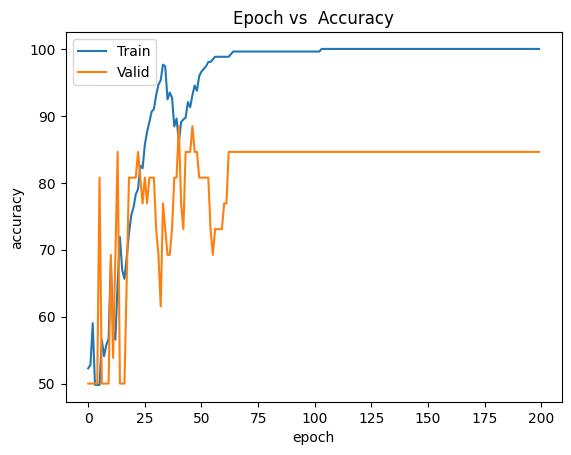

INFO:tensorflow:Assets written to: adv_KWS_transformer2/assets


INFO:tensorflow:Assets written to: adv_KWS_transformer2/assets


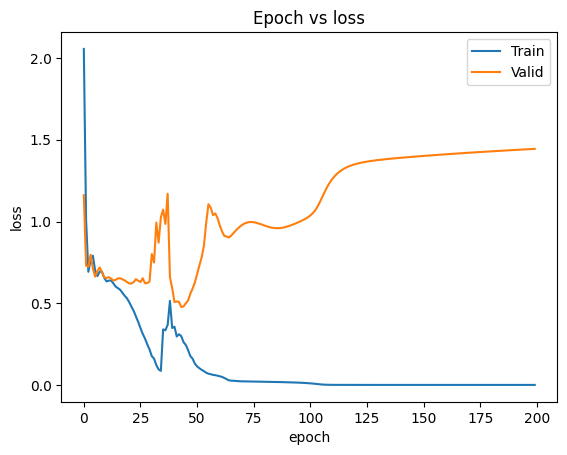

INFO:tensorflow:Assets written to: adv_KWS_transformer2/assets


INFO:tensorflow:Assets written to: adv_KWS_transformer2/assets


Attack started for testing
adv_tmp/test
adv_tmp/test/on
7.06111478805542
0 tf.Tensor(
[1.01253185e+01 1.04279861e+01 1.03641911e+01 1.00855989e+01
 1.76321890e-03 3.43502179e-04 9.52356052e+00 7.60266208e-04
 1.04085388e+01 3.75502204e-05 1.27865549e-03 3.15899633e-05
 1.14065898e-03 5.59170151e+00 1.43419945e+00 1.03935699e+01
 8.46915817e+00 6.42517407e-05 1.02032938e+01 9.97730541e+00
 1.03925028e+01 3.67157882e-05 1.05544977e+01 1.04135628e+01
 7.43510628e+00 1.03998871e+01 3.20100505e-03 1.02823887e+01
 1.18519145e-03 8.91645759e-05 1.01772366e+01 9.80709648e+00
 1.02306805e+01 9.95536709e+00 1.01687622e+01 2.87610659e-04
 1.74268789e-04 9.66082573e+00 1.00411377e+01 1.04181690e+01
 1.00976343e+01 9.68049335e+00 3.12323464e-05 7.77378178e+00
 4.59446252e-04 4.02012112e-04 3.63283907e-04 1.05511637e+01
 1.03358612e+01 6.71605635e+00 1.04669189e+01 1.04872103e+01
 5.67751878e-04 1.32472941e-03 1.04364614e+01 1.50986171e+00
 1.02705650e+01 1.04636726e+01 1.96782500e-02 3.54227261e-04

It's way over 0.20530612182617186
Worked i=49 loss=0.000676 bound=369.551025
First hit for audio 49 at iteration 99
It's way over 0.09913823699951171
Worked i=50 loss=0.000161 bound=178.448822
First hit for audio 50 at iteration 99
It's way over 0.12124479675292969
Worked i=51 loss=0.000028 bound=218.240631
First hit for audio 51 at iteration 99
It's way over 0.10410883331298829
Worked i=54 loss=0.000119 bound=187.395905
First hit for audio 54 at iteration 99
It's way over 0.19941059875488282
Worked i=55 loss=0.000304 bound=358.939087
First hit for audio 55 at iteration 99
It's way over 0.10445011138916016
Worked i=56 loss=0.000239 bound=188.010208
First hit for audio 56 at iteration 99
It's way over 0.09970072174072266
Worked i=57 loss=0.000189 bound=179.461304
First hit for audio 57 at iteration 99
It's way over 0.06921963500976562
Worked i=61 loss=0.000163 bound=124.595345
First hit for audio 61 at iteration 99
It's way over 0.10701482391357423
Worked i=62 loss=0.000180 bound=192.62

It's way over 0.0013459372520446778
Worked i=121 loss=0.000068 bound=2.422687
First hit for audio 121 at iteration 0
It's way over 3.0213011428713797e-05
Worked i=122 loss=0.000027 bound=0.054383
First hit for audio 122 at iteration 0
It's way over 0.0024870681762695314
Worked i=124 loss=0.000050 bound=4.476722
First hit for audio 124 at iteration 0
It's way over 2.4236559867858888e-05
Worked i=126 loss=0.000030 bound=0.043626
First hit for audio 126 at iteration 0
It's way over 0.0003813751041889191
Worked i=127 loss=0.000030 bound=0.686475
First hit for audio 127 at iteration 0
It's way over 0.08200850677490235
Worked i=0 loss=0.000028 bound=147.615311
First hit for audio 0 at iteration 99
It's way over 0.08200885772705079
Worked i=2 loss=0.000027 bound=147.615952
First hit for audio 2 at iteration 99
It's way over 0.08200356292724609
Worked i=5 loss=0.000030 bound=147.606415
First hit for audio 5 at iteration 99
It's way over 0.11853781127929687
Worked i=6 loss=0.000028 bound=213.36

NameError: name 'test_files' is not defined

In [18]:
start2=time.time()
data_dir =args.data_dir
train_ds, test_ds, val_ds, commands = collect_data(batch_size=args.batch_size, data_dir=data_dir)
print("train_ds, test_ds, val_ds uploaded")
model = KWS_transformer(
    image_size=(40, 98),
    patch_size=(20, 2),
    num_layers=args.num_layers,
    num_classes=len(commands),
    d_model=args.d_model,
    num_heads=args.num_heads,
    mlp_dim=args.mlp_dim,
    dropout=0
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True
    ),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=args.lr, weight_decay=args.weight_decay
    ),
    metrics=["accuracy"],
)
np.random.seed(1234)
perm = np.random.permutation(40)
best_val_acc = 0
train_loss=[]
val_loss=[]
train=[]
val=[]
with tf.device('/device:GPU:0'):
    for i in range(args.epochs):
        loss, acc, batches = 0, 0, 0
        for data, labels in train_ds:
            #generate adversarial samples using carlini and wagner attack here add it too the training phase
            # creation of combined adversarial and benign samples using concatentation
            #adv_data,labels=c&w(data,labels)
            #adv_mfccs=convert_to_mfccs(adv_data,perm=perm)
            #l,a=model.train_on_batch(adv_mfccs,labels)
            mfccs = convert_to_mfccs(data, perm = perm)
            l, a = model.train_on_batch(mfccs, labels)
            loss += l
            acc +=a
            
            batches += 1    
        train.append((acc/batches)*100)
        train_loss.append((loss/batches))    
        print(f"Epoch: {i}, Train: Loss: {(loss/batches)}, acc: {(acc/batches)*100}")
        loss, acc, batches=0,0,0
        if(i==0):   
            print("Attack started for training")
            start=time.time()
            adv_train_ds=cw_attack(val="train")
            end=time.time()
            
            print("Attack finished for training")
            print("attack time",end="")
            print(end-start)
            print(" Adversarial training completed for {iterate} iteration".format(iterate=i+1))
            print("\n\n\n\n\n")
            for adv_data,labels in adv_train_ds:
                mfccs=convert_to_mfccs(adv_data,perm=perm)
                adv_l,adv_a=model.train_on_batch(mfccs,labels)
                loss+=adv_l
                acc+=adv_a
                batches+=1
            print(f"Epoch: {i}, Adv Train: Loss: {(loss/batches)}, acc: {(acc/batches)*100}")
    
        loss, acc, batches = 0, 0, 0
        for data, labels in val_ds:
            mfccs = convert_to_mfccs(data, perm = perm)
            l, a = model.test_on_batch(mfccs, labels)
            loss += l
            acc += a
            batches += 1
        val.append((acc/batches)*100)
        val_loss.append((loss/batches))   
        print(f"Epoch: {i}, Val: Loss: {(loss/batches)}, acc: {(acc/batches)*100}")
        if acc > best_val_acc:
            best_val_acc = acc
            model.save_weights("best_weights")
plt.plot(train)
plt.plot(val)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Epoch vs  Accuracy')
plt.show()         
model.save(args.save_dir)
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Epoch vs loss')
plt.show()
model.save(args.save_dir)
test_ds = test_ds.batch(args.batch_size)
loss, acc, batches = 0, 0, 0
print("Attack started for testing")
start3=time.time()
adv_test_ds=cw_attack(val="test")
end3=time.time()
print("Attack finished for testing")
print("attack time",end="")
print(end3-start3)
adv_test_ds = adv_test_ds.batch(args.batch_size)
#print(" Adversarial training completed for {iterate} iteration".format(iterate=i+1))
print("\n\n\n\n\n")
for data, labels in test_ds:
    mfccs = convert_to_mfccs(data, perm = perm)
    l, a = model.test_on_batch(mfccs, labels)
    loss += l
    acc += a
    batches += 1
for data,labels in adv_test_ds:
    mfccs = convert_to_mfccs(data, perm = perm)
    l, a = model.test_on_batch(mfccs, labels)
    loss += l
    acc += a
    batches += 1
    
print(f"Test: Loss: {(loss/batches)}, acc: {(acc/batches)*100}")
end2=time.time()
print("\n\n\n\n\n")

print(end2-start2)

In [ ]:
#adv_train_dir=
os.makedirs("tp/{val}".format(val=0), exist_ok=True)